<img src="./img/HWNI_logo.svg"/>

# Lab 11 - Classification

In [1]:
%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import sklearn as sk

# choose colors that work for most color-blind folks
sns.set_palette("colorblind")
sns.set(color_codes=True)

import util.lab11utils as utils

utils.formatDataframes()

## Introduction

So far, we have focused on models that connect two variables that can take on any of an infinite number of values -- body weight and brain weight, for example. These are called *continuous* variables, and models that use a continuous variable to predict a continuous variable are called *regression* models.

Frequently, however, the variable we want to predict only takes on one of two or a small number of values: did the mouse get the disease, or did it not? did the neuron fire an action potential, or did it not? was the weather sunny, cloudy, rainy, or extreme? and so on. These are called *discrete* variables, and models that use a continuous variable to predict a discrete variable are called *classification* models or *classifiers*.

As an aside: what about models that use a discrete variable to predict a continuous variable? The most common example is the *Analysis Of VAriance* model, or *ANOVA*.

## Specifying Classification Models

In a classification problem, we are given pairs of observations and labels and we want to come up with a "classifier", a function that can

1. correctly assign as many of the observed labels to the observed values as possible
1. given new observations, predict the correct label

It's useful to think of our classifier as solving two problems: first, it calculates the probability that the given point would have each label. Then, it uses some decision rule to choose a label based on the relative probabilities. 

If our goal is to maximize the probability that our prediction is correct, then the decision rule is easy: simply pick the label with the largest probability.

So the meat of our classifier is in how it solves the first problem: calculating the conditional probability of each label given the provided data point.

How do we pick the best classifier? We can make headway by using the principle of maximum likelihood: when given the choice between a bunch of classifiers, we pick the classifier that maximizes the likelihood function of the data.

$$
    \text{best classifier} = \arg\!\max_\text{classifiers} \prod_\text{dataset} p_\text{classifier}(\text{true label}\ |\ \text{observation})
$$

Here $p_\text{classifier}$ means "the probability distribution the classifier uses to make its decision". As we change our classifier, this distribution will change. We're looking for the one that maximizes the likelihood.

While this expression is intuitive, it's unfortunately not usable by itself -- how do we relate the form of a classifier to $p_{\text{classifier}}$? how do we maximize over "classifiers"? In the following, we'll rewrite this into a more usable form.

### The Bernoulli Distribution

As a first step, we need to figure out how to write down a probability distribution for our label variable. We need to do a bit of work here because we've primarily considered distributions for continuous variables.

In order to simplify the math, let's assume that there are only two labels. These labels could be "sick" and "healthy" or "active neuron" and "inactive neuron" or, more generally, "class A" or "class B". Because it only has two values, we call our label a *binary* variable.

It's easy to write down the probability distribution for a binary variable. There's only one parameter, indicated, as is tradition, by $\theta$, which tells us the probability of getting one of the outcomes. That's all we need, since then the probability of the other outcome is just $1-\theta$.

$$
p(\text{label A}\ \lvert\ \theta) = \theta \\
p(\text{label B}\ \lvert\ \theta) = 1-\theta
$$

This kind of a probability distribution is called a *Bernoulli distribution*, after [Jacob Bernoulli](https://en.wikipedia.org/wiki/Jacob_Bernoulli), a 17th century Swiss physicist and mathematician who wrote one of the foundational works in probability, [*Ars Conjectandi*](https://en.wikipedia.org/wiki/Ars_Conjectandi). It's the probability distribution of a coin flip (using the labels "heads" and tails"), with parameter $\theta=0.5$ if the coin is fair.

In order to make our labels work with our math, we need to turn our labels into numbers. It will turn out to be convenient to choose the numeric labels "0" and "1". This lets us cleverly rewrite the Bernoulli distribution above as

$$
p(\text{label}\lvert\theta) = \theta^{\text{label}}(1-\theta)^{1-\text{label}}
$$

There's nothing here that wasn't in the original description above. We've simply rewritten it in a form that lets us talk about $p(Y\lvert\theta)$ as a single function, instead of one function for $Y=1$ and another for $Y=0$. We achieved this by multiplying the two original functions by each other and then adding in exponents so that each term is 1 when it's not being used.

### Applying Maximum Likelihood

Let's plug the Bernoulli distribution into our maximum likelihood expression, then convert to the "minimum surprise" from by taking the negative log of the likelihood.

$$
\begin{align}
    \text{best classifier} &= \arg\!\max_\text{classifiers} \prod_\text{dataset} p_\text{classifier}(\text{true label}\ |\ \text{observation}) \\
     &= \arg\!\max_\text{classifiers} \prod_\text{dataset}
                 p_\text{classifier}(\text{label} = 1\ |\ \text{observation})^\text{true label}
                 p_\text{classifier}(\text{label} = 0\ |\ \text{observation})^{1-\text{true label}} \\
     &= \arg\!\min_\text{classifiers} -\sum_\text{dataset}
                 \log \left(p_\text{classifier}(\text{label} = 1\ |\ \text{observation})^\text{true label}
                 p_\text{classifier}(\text{label} = 0\ |\ \text{observation})^{1-\text{true label}}\right) \\
     &= \arg\!\min_\text{classifiers} \sum_\text{dataset} 
                     \text{true label}*-\log p_\text{classifier}(\text{label} = 1\ |\ \text{observation}) \\
                & \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 
                +(1-\text{true label})*-\log p_\text{classifier}(\text{label} = 0\ |\ \text{observation}) \\
\end{align}
$$

This looks complicated, but it's not once you break it down, term by term and line by line. 

First, notice that the true label for a data point is always $0$ or $1$, so only one of the two terms inside the sum will be non-zero. 

Let's focus on the first term. It says that, when the true label is $1$, the thing we want to minimize is the negative log probability under the model, or model's *surprise*, that the provided observation has label $1$. The second term says to reduce the surprise that the observation has the label $0$, but only when the true label is $0$. This is similar to how we fit our regression models, where our goal was also to be minimally surprised by the data we saw.

One last trick will let us write the whole thing in terms of the probability that the label is $1$. Noting that the probability that the label is $0$ is just 1 minus this value, we write:

$$
\begin{align}
    \text{best classifier}&= \arg\!\min_\text{classifiers} \sum_\text{dataset} 
                \text{true label}*-\log p_\text{classifier}(\text{label} = 1\ |\ \text{observation}) \\
                 & \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \
                 +(1-\text{true label})*
                 -\log\left( 1 - p_\text{classifier}(\text{label} = 1\ |\ \text{observation})\right) \\
\end{align}
$$

This lets us simplify the main component of our classifier, the part that calculates the conditional probability distribution of the labels. We can think of it as just calculating the probability that the label is $1$. This is just a single-output function of the observation, so we can re-write the above as:

$$
\begin{align}
    \text{best classifier}&= \arg\!\min_{\text{functions } f} \sum_\text{dataset} 
                \text{true label}*-\log f(\text{observation})
                 +(1-\text{true label})*-\log\left( 1- f(\text{observation})\right) \\
\end{align}
$$

To save space, let's introduce the symbols $X$ for the observation and $Y$ for the label:

$$
\begin{align}
    \text{best classifier}&= \arg\!\min_{\text{functions } f} \sum_\text{dataset} 
                Y*-\log f(X)
                 +(1-Y)*-\log\left( 1- f(X)\right) \\
\end{align}
$$

Our goal in designing classifiers will now be to pick families of functions to optimize the above expression over. Perhaps linear, linearized, and nonlinear functions?

Unfortunately, we can't just plow ahead with same families we used for regression. Our functions are already very special: they represent conditional probabilities.

If we try to directly fit a linear model to a classification dataset, disaster can strike. Below, we load the classic `iris` dataset and fit a linear model that tries to predict the binary variable indicating whether a given flower is an *Iris setosa* based on the width of its sepal leaf. This was [one of the first datasets used for classification](https://en.wikipedia.org/wiki/Iris_flower_data_set), originally by [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher).

In [2]:
data = sns.load_dataset("iris")

data["is setosa?"] = data["species"] == "setosa"

<IPython.core.display.Javascript object>


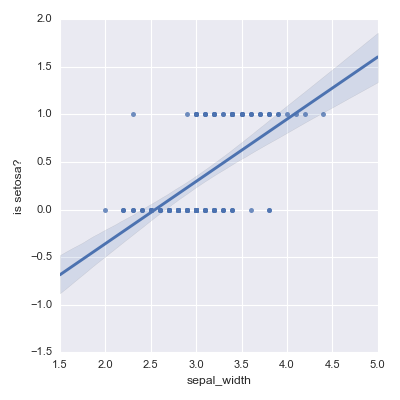

In [3]:
sns.lmplot(data=data,x="sepal_width",y="is setosa?",logistic=False,ci=95,);

#### Q1 Why is this linear model a bad model for the conditional probability?

<font color=1874CD> <b> It can go above 1 or below 0.

#### Q2 What would happen to the fitted line if we were to observe another point, this one with a `sepal_width` of 5 that was a *setosa*? What if we observed 100 points like that? Why is this bad?

<font color=1874CD> <b> The line would tilt in that direction, and hard: under an assumption of Gaussian noise, such an observation is extremeley unlikely. If we observed one hundred points like that, the line would be pulled to go through that point,

### Enter the Logistic Function

This is a shame. Our use of parametric families of functions was huge for expanding our regression models. It let us transform optimizations over functions (which are defined at an infinite number of points!) into optimizations over parameters, which we get to pick the number of. 

Our solution is to split $f$ into two parts: one function, $\phi$, that can take on any form, and another function, $\sigma$, that takes functions of any form and turns them into valid conditional probabilities. That is, $\sigma$ is a function that takes any number and returns a number between 0 and 1.

The function we use is called the *logistic* function. Mathematically, it looks like this:

$$
\sigma(x) = \frac{1}{1+\mathrm{e}^{-x}}
$$


As a graph, it looks like:

<IPython.core.display.Javascript object>


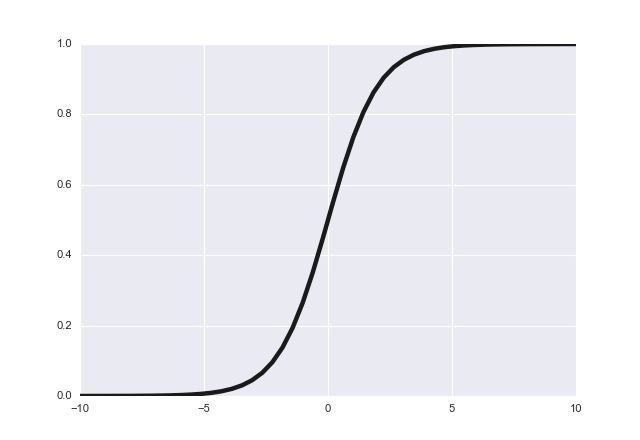

In [4]:
utils.plotLogistic()

The logistic function is used because it connects the *log-odds ratio* that each class would produce the observation to the conditional probability of a class given the observation. For more, see the addendum at the end of the lab.

In this form, our classifier problem is written:

$$
\begin{align}
    \text{best classifier} &= \arg\!\min_{\text{functions } \phi} \sum_{dataset} 
                Y*-\log \sigma(\phi(X))
                 +(1-Y)*-\log\left( 1- \sigma(\phi(X))\right) \\
\end{align}
$$

We can interpret this as a cost function called the *cross-entropy*. For more on this important function, see the second addendum.

We can now pick our favorite parametric function family and use it, without issue, as the core component of a classifier.

We now turn to examining the three types of classifiers derived from our three function families, and end by considering classifiers that fall outside of the logistic schema, nonparametric classifiers.

### Linear Classifiers

A linear classifer is a classifier that uses a linear function $\phi$. Linear functions can be written as dot products, so we can write

$$
\begin{align}
    \text{best linear classifier} &= \arg\!\min_{\phi} \sum_{dataset} 
                Y*-\log \sigma(\phi^T X)
                 +(1-Y)*-\log\left( 1- \sigma(\phi^T X)\right) \\
\end{align}
$$

Finding a linear classifier is also called *logistic regression*.

Whenever $\phi^T X$ is greater than $0$, we predict that $X$ has label 1, because then $\sigma(0)$ is greater than $0.5$. Remember that the output of $\sigma$ is the conditional probability that $X$ has label 1. Similarly, we predict that $X$ has label 0 whenever $\sigma$ is less than 0.

The set of points $D$ where $\phi^T D$ is exactly 0 are called the *decision boundary* of our model. This is the set of all vectors that are orthogonal to the vector $\phi$. Therefore the decision boundary is a point in one dimension, a line in two dimensions, or a plane in three dimensions. Since we usually augment our data with a constant vector, this point/line/plane doesn't need to go through the origin.

Notice that the dimension of each boundary is one dimension less than the dimension of the space. The generalization of this idea to dimensions greater than 3 is the *hyperplane*. Notice also that each boundary divides the space into only two parts.

First, let's apply logistic regression to the dataset from above.

<IPython.core.display.Javascript object>


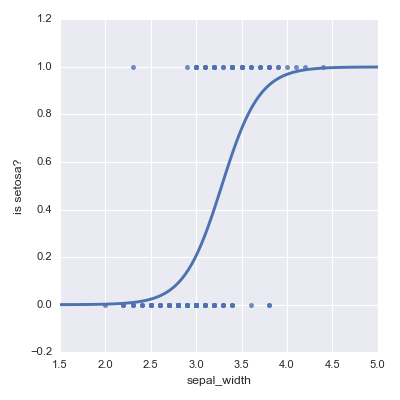

In [5]:
sns.lmplot(data=data,x="sepal_width",y="is setosa?",logistic=True,ci=None);

#### Q3 How does it perform?

<font color=1874CD> <b> Much better!

Consider the situation that caused an issue for our linear regression model: we observe many points that have label `1` and a `sepal_width` of `5`.

#### Q4 How would the linear classifier's behavior be different (better) than the linear regression model's behavior?

<font color=1874CD> <b> These points would be well-predicted by the model, so the pull of these values will be smaller than the pull of the rest of the data points, and the model will continue to behave well.

### Linearized Classifiers

Though it's not particularly common, it's certainly possible to make a linearized classifer. As before, we introduce a nonlinear function $f$ that transforms or augments $X$ before the parameters, $\phi$, do a linear transformation of this output. For example, in a polynomial linearized model, $f$ would be a function that returns the input, the square of the input, the cube of the input, and so on.

$$
\begin{align}
    \text{best linear classifier} &= \arg\!\min_{\phi} \sum_{dataset} 
                Y*-\log \sigma(\phi^T f(X))
                 +(1-Y)*-\log\left( 1- \sigma(\phi^T f(X))\right) \\
\end{align}
$$

However, the use cases for linearized classifiers are pretty limited. Linearized models rely on strong hypotheses about the relationship between the input variables and the outputs, which are often harder to formulate in the setting of classification than in regression.

### Parametric Nonlinear Classifiers

Instead, when folks want to perform classification without assuming a linear model, they use flexible parametric nonlinear classifiers. If we call the parameters $\theta$, we can write our classifier optimization problem as:

$$
\begin{align}
    \text{best parametric nonlinear classifier} &= \arg\!\min_{\theta} \sum_{dataset} 
                Y*-\log \sigma(\phi(X,\theta))
                 +(1-Y)*-\log\left( 1- \sigma(\phi(X,\theta))\right) \\
\end{align}
$$

Frequently, these classifiers have stacked linear-nonlinear transformations, with the parameters only modifiying the linear transformation. These are called *neural networks*. The decision boundaries of a neural network are much more complex than simple hyperplanes, so they can separate labels that are heavily intertwined in the data space. If you'd like to see some neural networks in action tackling simple but difficult classification problems, check out Google's [Neural Network Playground](http://playground.tensorflow.org/).

### Non-Parametric Classifiers

We can also do classification in a non-parametric way. 

The most common approach is called *k-nearest-neighbors*. In a nearest-neighbors approach, we drop the idea of using maximum likelihood and just adopt the heuristic that points in the same class are more likely to be closer to each other. To predict the class of a new, unlabeled datapoint, we simply look around at the *k* closest points in the dataset and take a "majority vote" on what the class label should be.

This approach is powerful and flexible in that, given enough data, it can perform well when classifying data from absolutely any distribution. It's not without its drawbacks, however.

#### Q5 Based on what you've learned about modeling, what do you expect to be drawbacks to nearest-neighbors classification?

<font color=1874CD> <b> Because it's nonparametric, we expect that it will have a tendency to overfit the data and be unreliable unless the amount of data provided is large. Also, nonparametric models require you to keep the entire dataset around, which can be prohibitive when that dataset is, say, an image of very face you've ever seen in your life.

## Visualizing Classification Models

As we did for regression, we can visualize the implicit models of our classifiers. As before, we look at the output of our classifier before it makes the classification decision, i.e. after $\sigma(\phi(X))$, as a function of $X$. 

We plot the model output as a surface -- the input dimensions on the x and y axes and the output on the z axis. The z height is also indicated using color. The scale runs from red at 0 to blue at 1, with white at 0.5. Red thus indicates a high probability of label 0 and blue a high probability of label 1.

We also visualize, with a scatter plot, a random dataset generated according to the model's conditional distribution. Inputs are again plotted on the x and y axes and label on the z axis. A black dot has label 1 and a white dot label 0.

#### Linear Classifiers

First, we look at a linear classifier. The function `plotLinearModel` will generate a random linear classifier, then plot it as described above. If you want to see a particular linear classifier, pass a specific set of weights, as indicated below.

<IPython.core.display.Javascript object>


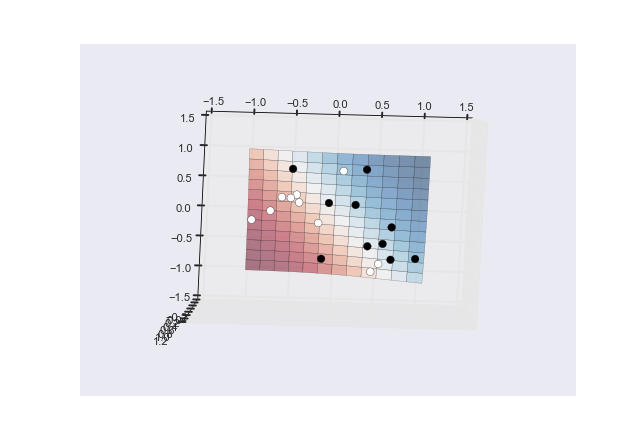

In [6]:
utils.plotLinearModel()
#utils.plotLinearModel(weights = np.asarray([[5.,2.,1.25,]]).T)

#### Q6 How do you determine the decision boundaries of a model using this chart?

<font color=1874CD> <b> Either 1) look for white color on the surface, which indicates an output of 0.5, or 2) look for where the surface has a height of 0.5

#### Q7 What do the decision boundaries for linear classifiers look like?

<font color=1874CD> <b> Straight lines.

#### Linearized Classifier

Next, we consider linearized classifiers: models that apply a linear $\phi$ to multiple fixed non-linear transformations of its input.

Three linearized models with different weights and non-linearities are defined by `generateLinearizedModels` and stored in the dictionary `phi_f`. Their keys are `quadratic`, `trig` and `checker`. You can adjust which model is plotted by changing the value of `model` in the cell below.

<IPython.core.display.Javascript object>


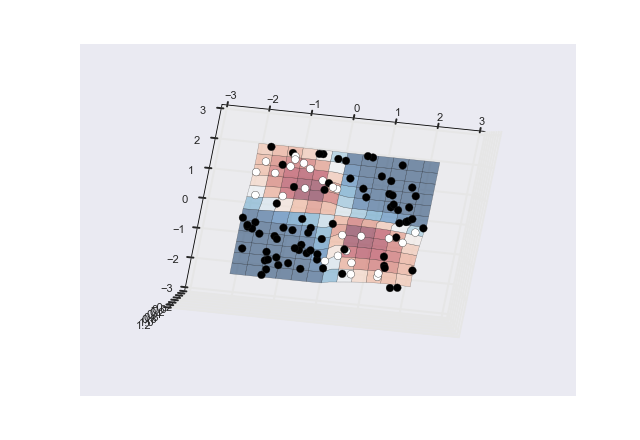

In [14]:
phi_f = utils.generateLinearizedModels()

model = 'checker'

utils.plotLinearizedModel(phi_f[model],extent=2)

Try out each model: `quadratic`, `trig`, and `checker`.

#### Q8 What do the decision boundaries look like for each model?

<font color=1874CD> <b> For the quadratic, there's one decision boundary that's circular in shape. For the trigonometric model, there are two ellipsoid decision boundaries. For the checker model, the decision boundaries roughly follow the axes.

## Model Fitting and Model Accuracy for Classification

In general, we can't find a closed-form solution for the classifier that minimizes our cost function. Instead, we have to use gradient descent, even in the linear case.

The usual metric for accuracy is percent correctly classified. This metric has the same issues that $R^2$ has -- the value on the sample is biased upwards and would favor more complex, overfit models, and the cross-validated value is biased downwards but doesn't favor any particular model.

To perform gradient descent, we'll use [scikit-learn](http://scikit-learn.org/stable/). Scikit-learn is the premier Python toolbox for implementing established algorithms for classification, regression, and many other machine learning problems.

The cell below (adapted from [an example](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py) in the [`sklearn` documentation](http://scikit-learn.org/stable/documentation.html)) will run up to three classifiers: a linear classifier (`SVC`), a neural network classifier (`MLPClassifier`), and a nearest-neighbors classifier (`KNeighborsClassifier`). These are provided via the list `classifiers`. Keep them in the same order, commenting out whichever you're not currently using.

The details of the figure are explained below. 

<IPython.core.display.Javascript object>


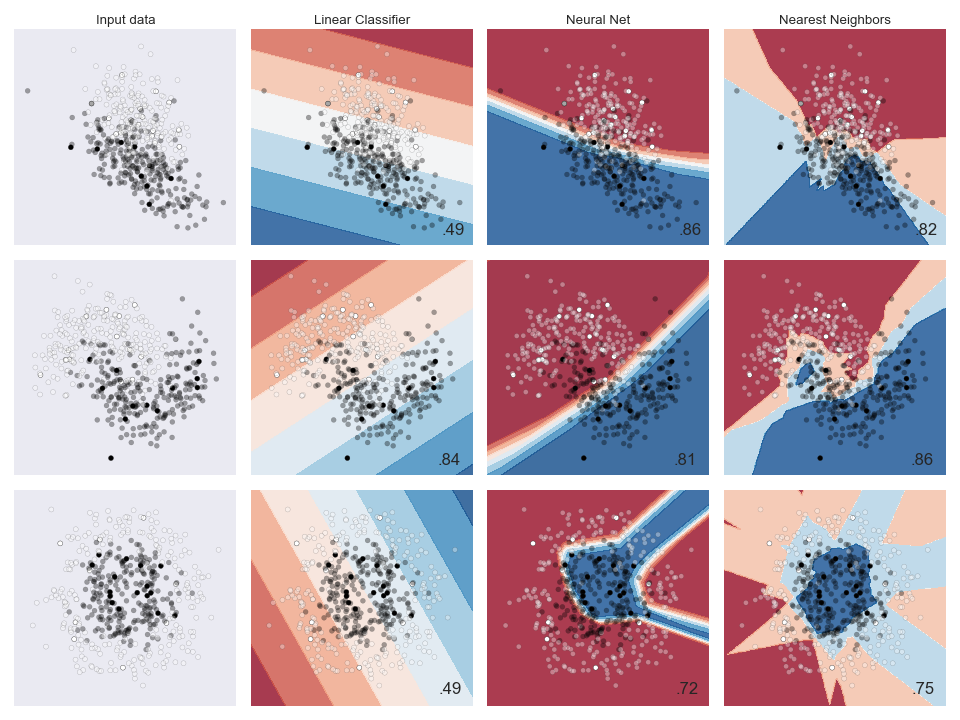

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

N = 500
holdout = .95

# hyperparameter for nearest-neighbors
k = 3

# hyperparameter for neural net
hidden_layer_sizes = [10,5,2]

classifiers = [
    SVC(kernel="linear", C=0.025),

    MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                  alpha=0.05,max_iter=2500,
                 learning_rate = "invscaling"),
    
    KNeighborsClassifier(k),
]

utils.runClassifiers(classifiers,N=N,holdout=holdout)

The left column of the figure shows the three datasets. Each dataset has two dimensional input, and the label is indicated by color. The size of the dataset is determined by `N`. 

The accuracy of each model is calculated using hold-out cross-validation. Results are printed in the bottom-right corner of each figure. To get a precise measurement of the model's accuracy, we pick a large `N` and a large `hold-out` fraction. For a more realistic view of what you'd get if you tried to calculate these values yourself, try a smaller `N` with a smaller `holdout` fraction -- `.4` or `.2`. 

The datapoints that are held out are transparent, while the datapoints used for training are opaque. For the scattered points, color indicates the class label of the datapoint. The background color indicates the output of the classification model at that point in the input space -- blue values correspond to higher probabilities for the black class label and red values to higher probabilities for the white class label. 

#### Q9 Describe the linear classifier's performance. When does it succeed? When does it fail?

<font color=1874CD> <b> The linear classifier does best when a straight line can cut the data in half in a way that puts more each label on opposite sides of the line.

#### Q10 Compare the third dataset to the second dataset. Which one does the linear model do better on? Can you explain why?

<font color=1874CD> <b> The model does much better on the second dataset than the third because there is a decent linear boundary in the second dataset, while on the third dataset, no linear boundary does much better than chance. 

Uncomment the `MLPClassifier`.

#### Q11   What's different about the solutions the neural network finds? 

<font color=1874CD> <b> The neural network finds solutions with nonlinear decision boundaries.

Run the fitting cell multiple times. Notice that the data, including the hold-out set, doesn't change from run to run (it's being generated pseudo-randomly with a fixed seed).

#### Q12 Does the solution found by the neural network differ from run to run? What about that of the linear classifier? Explain. Recall that both are fit via gradient descent.

<font color=1874CD> <b> Yes for the neural new, no for the linear classifier. This must mean that the cost function for the linear classifier doesn't have local minima.

#### Q13 Does the neural network ever fail drastically? Why might this be?

<font color=1874CD> <b> Yes. There are some bad local minima in the cost function of the neural network.

Increase `holdout` to `0.95` (effectively decreasing the size of the dataset) and again run the fitting cell multiple times.

#### Q14 How has the neural network's performance changed? What about the solutions it finds?

<font color=1874CD> <b> The neural network starts to perform much more poorly, and the local minimum problem becomes worse. The solutions appear more overfit.

Return the `holdout` to `.75`. Uncomment the `KNeighborsClassifier`.

#### Q15 Compare and contrast the behavior of the neural network and the nearest-neighbors classifier. Does the nearest-neighbors classifier change from run to run? How is its performance? What do its decision boundaries look like?

<font color=1874CD> <b> The nearest-neighbors classifier is the same from run to run. It performs roughly as well as the neural network, but its decision boundaries are rougher and perhaps more overfit.

#### Q16 Do the decision boundaries found by the neural network or the nearest-neighbors classifier look closer to the ones you'd draw yourself?

<font color=1874CD> <b> For me, the neural network looks closer to the contours I'd draw.

Decrease `holdout` to `0.2`, effectively increasing the dataset size.

#### Q17 Does this change your answer to the above question?

<font color=1874CD> <b> Nope! The neural network's contours become smoother and seem to be getting closer to the true model I'd posit for the data, while the nearest-neighbors model remains jagged.

Some of the hyperparameters for the two nonlinear models are exposed so that you can vary them. A hyperparameter is any number that affects the model but that we don't directly learn from the data.

The two exposed hyperparameters are `k`, the number of neighbors used by the nearest-neighbors model and the list `hidden_layer_sizes`, listing the sizes of the hidden layers of the neural network (and therefore also how many layers there are). These can interact in interesting ways like the size of the dataset.

#### Q18 Do you notice anything else interesting? Write your notes here.

### Addenda

#### Addendum on the log odds ratio and the logistic function

Suppose we have two variables, $A$ and $B$, where $B$ is a binary variable. The log odds ratio is the following function of $A$:

$$
    \text{log odds ratio of A and B} = \log{\frac{p(A \lvert B = 1)}{p(A \lvert B = 0)}} = \log OR(A,B)
$$

It is the log of the ratio of probability of $A$ conditioned on the value of $B$ (probabilites were once known in mathematics, as they still are in everyday life, as the *odds*). 

The odds ratio is the only quantity needed to use the observation of the value of $A$ to make a decision that has a payoff or cost that depends on whether $B$ was $1$ or $0$. By extension, the log odds ratio also works. The log odds ratio is usually more mathematically convenient.

We can start from the conditional probability that we use for our classifier, $p(Y=1\lvert X)$ and rewrite it in terms of a log odds ratio. In the process, the logistic function pops out.

We first use Bayes' Rule, then we multiply the whole expression by $\frac{p(X\lvert Y=1)}{p(X\lvert Y=1}$, cancel terms, and then use the fact that $x = \mathrm{e}^{\log(x)}$.

$$
    \begin{align}
        p(Y=1\lvert X) &= \frac{p(X\lvert Y=1)}{p(X\lvert Y=1)+p(X\lvert Y=0)} \\
                        &= \frac{1}{1+\frac{p(X\lvert Y=0)}{p(X\lvert Y=1)}} \\
                        &= \frac{1}{1+\frac{p(X\lvert Y=0)}{p(X\lvert Y=1)}} \\
                        &= \frac{1}{1+\mathrm{e}^{-\log \frac{p(X\lvert Y=1)}{p(X\lvert Y=0)}}} \\
                        &= \frac{1}{1+\mathrm{e}^{-\log OR(X\lvert Y=1,X\lvert Y=0)}} \\
                        &= \sigma\left(\log OR(X,Y)\right)
    \end{align}
$$

This lets us rethink, once more, what our classifier is doing. It's searching for a function that approximates the log odds ratio and then using the logistic function to transform that log odds ratio into a conditional probability. The log odds ratio isn't constrained the way a probability distribution is, so we don't need to worry about whether the function our classifier is learning fits any constraints.

#### Addendum on the cost function for classification

The following was our final, general form for finding the best classifier:

$$
\begin{align}
    \text{best classifier} &= \arg\!\min_{\text{functions } \phi} \sum_{dataset} 
                Y*-\log \sigma(\phi(X))
                 +(1-Y)*-\log\left( 1- \sigma(\phi(X))\right) \\
\end{align}
$$

Notice how similar this is to a regression problem: there's a function of our input data, $\sigma(\phi(X))$, and we're comparing it to our observed outputs and finding the best one according to a cost function. Denoting $\sigma(\phi(X))$ as $p_{classifier}(Y=1\ \lvert X)$, we can write this cost function as: 

$$
\begin{align}
\text{classifier cost} & = \sum_\text{dataset} Y*-\log p_{classifier}(Y=1\ \lvert X)
                         +(1-Y)*-\log\left( 1- p_{classifier}(Y=1\ \lvert X)\right) \\
                 & = \sum_\text{dataset} Y*-\log p_{classifier}(Y=1\ \lvert X)
                         +(1-Y)*-\log\left(p_{classifier}(Y=0\ \lvert X)\right) \\
\end{align}
$$

Again, only one of the two terms is non-zero at a time. We can interpet the $Y$ and $1-Y$ terms as representing the probability, under the empirical distribution of the data, that the label is $Y$ for a point at $X$. Under the empirical distribution, this probability is either $0$ or $1$.

That means our cost function is actually computing the average surprise of our model -- using the model distribution to compute the surprise and the empirical distribution to weight the averaging. The average surprise is an important quantity in Claude Shannon's [theory of information](http://charlesfrye.github.io/stats/2016/03/29/info-theory-surprise-entropy.html), where it is called the [*cross-entropy*](https://en.wikipedia.org/wiki/Cross_entropy).

In machine learning settings, where the statistical interpretation of models is often implicit, the cross-entropy simply shows up as a cost function, just like the squared error. For this reason, classification and regression aren't always distinguished from each other in contemporary machine learning methods -- the only difference between two models, often, is in this choice of cost function.